# 1. Dependencies

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU ,Dense, Dropout
from gensim.models import Word2Vec

Data set: https://ieee-dataport.org/open-access/fnid-fake-news-inference-dataset?check_logged_in=1

# 2.Data Processing 

In [ ]:
#Load the dataset
df = pd.read_csv('data/fake_news_dataset.csv')

df.info()

## Dataset Attributes Description

- **id** – A unique identifier for each news record.  
- **date** – The date and time when the news statement was made or published.  
- **speaker** – The person or organization that made the statement.  
- **statement** – The main claim or headline under evaluation.  
- **sources** – References or URLs that provide supporting information.  
- **paragraph_based_content** – News content broken into paragraphs for analysis.  
- **fullText_based_content** – The complete text of the news article or statement.  
- **label_fnn** – Label indicating whether the news is fake or real (text label).  
- **news_label** – Numeric label for fake (0) or real (1) news (used for ML tasks).  
- **label-liar** – Alternative label from the LIAR dataset (may be empty for some rows).


Data source: https://www.kaggle.com/datasets/mdepak/fakenewsnet?select=PolitiFact_fake_news_content.csv

In [ ]:
#Drop redundant columns
df.drop(columns=['id', 'date', 'paragraph_based_content','label_fnn','label-liar'],inplace=True)

- Remove id & date because they do not give any information whether the news is real/fake
- Remove paragraph_based_content because it's a shorter version of fullText_based_content
- Remove label_fnn,label-liar because the news_label already labeled the fake/real news


## Process speaker column

In [ ]:
#Get the top 50 top speaker(the speaker with most speechs) & label the rest with 'other'
df['speaker'] = df['speaker'].str.lower().str.strip()
top_speakers = df['speaker'].value_counts().head(50).index
df['speaker_grouped'] = df['speaker'].where(df['speaker'].isin(top_speakers), 'other')

In [ ]:
#Label encoding 
le = LabelEncoder()
df['speaker_grouped'] = le.fit_transform(df['speaker_grouped'])
df['speaker_grouped'].head()
joblib.dump(le, 'models/speaker_label_encoder.joblib')

0     6
1    31
2    31
3    31
4    31
Name: speaker_grouped, dtype: int32

## Process source column

In [ ]:
def parse_sources(source_string):
    try:
        return ast.literal_eval(source_string)
    except:
        return []

df['sources_list'] = df['sources'].apply(parse_sources)

In [ ]:
#num_sources: count the number of sources per statement
df['num_sources'] = df['sources_list'].apply(len)

In [ ]:
def extract_domains(urls):
    return [urlparse(url).netloc for url in urls]

df['source_domains'] = df['sources_list'].apply(extract_domains)

In [ ]:
#check if there is government source in source domain
df['has_official_source'] = df['sources_list'].apply(
    lambda urls: 1 if any('.gov' in url or '.org' in url for url in urls) else 0
)

In [ ]:
df.drop(columns=['sources','sources_list','source_domains'], inplace=True)

In [ ]:
#Save the processed dataset
df.to_csv('data/cleaned_dataset.csv', index=False)

# 3.Data Visualization

In [ ]:
df = pd.read_csv('data/cleaned_dataset.csv')

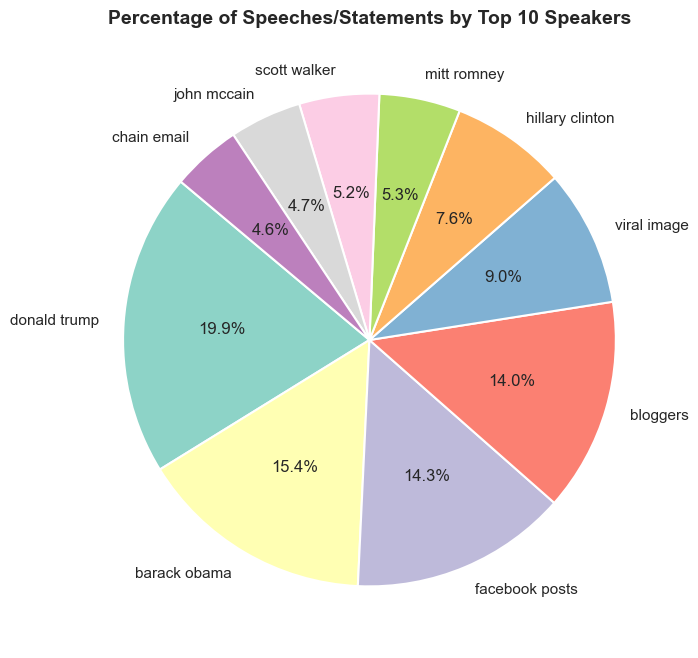

In [ ]:
# Filter out 'other' speakers
df_filtered = df[df['speaker'].notna() & (df['speaker'] != '')]

# Compute top 10 speakers
top_speakers = df_filtered['speaker'].value_counts().head(10)

# Set theme
sns.set_theme(style='whitegrid')

# Plot
plt.figure(figsize=(8, 8))
colors = sns.color_palette('Set3', len(top_speakers))

plt.pie(
    top_speakers.values,
    labels=top_speakers.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

plt.title('Percentage of Speeches/Statements by Top 10 Speakers', fontsize=14, fontweight='bold')
plt.show()

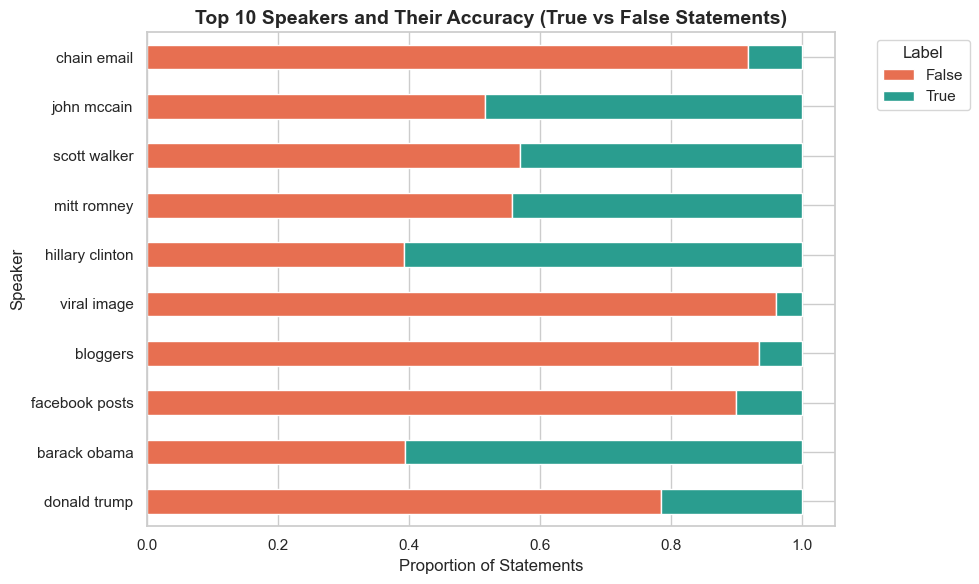

In [ ]:
label_map = {0: 'False', 1: 'True'}
df['label_text'] = df['news_label'].map(label_map)

# Count number of statements per speaker per label
speaker_label_counts = df.groupby(['speaker', 'label_text']).size().unstack(fill_value=0)

# Get top 10 speakers with most total statements
top_speakers = speaker_label_counts.sum(axis=1).sort_values(ascending=False).head(10)
top_speaker_data = speaker_label_counts.loc[top_speakers.index]

# Normalize counts to proportions (accuracy rates)
top_speaker_props = top_speaker_data.div(top_speaker_data.sum(axis=1), axis=0)

# Plot
top_speaker_props.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=['#e76f51', '#2a9d8f']  # green for true, red for false
)

# Titles and labels
plt.title('Top 10 Speakers and Their Accuracy (True vs False Statements)', fontsize=14, fontweight='bold')
plt.xlabel('Proportion of Statements')
plt.ylabel('Speaker')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

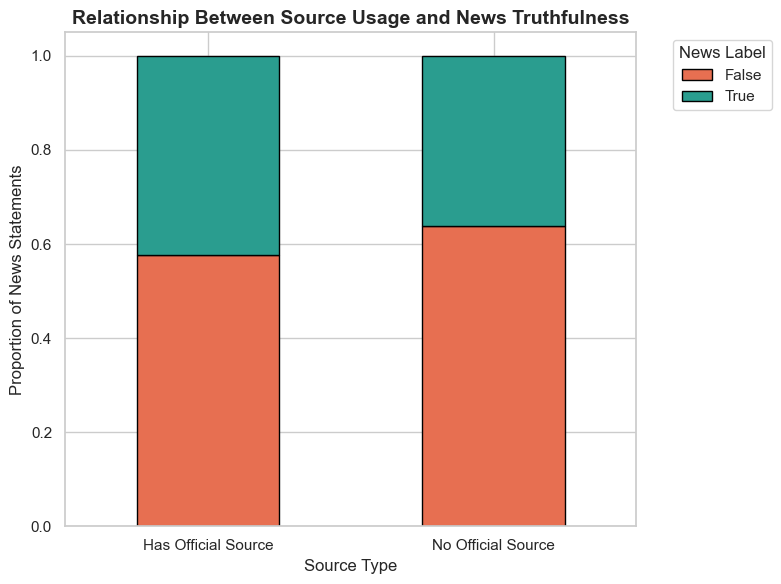

In [ ]:
# Map labels for readability
label_map = {0: 'False', 1: 'True'}
df['label_text'] = df['news_label'].map(label_map)
df['source_label'] = df['has_official_source'].map({0: 'No Official Source', 1: 'Has Official Source'})

# Count number of statements by truth label and source type
source_counts = df.groupby(['source_label', 'label_text']).size().unstack(fill_value=0)

source_props = source_counts.div(source_counts.sum(axis=1), axis=0)

# Plot stacked bar chart (without annotations)
ax = source_props.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    color=['#e76f51', '#2a9d8f'],  
    edgecolor='black'
)

# Titles and labels
plt.title('Relationship Between Source Usage and News Truthfulness', fontsize=14, fontweight='bold')
plt.xlabel('Source Type')
plt.ylabel('Proportion of News Statements')
plt.legend(title='News Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

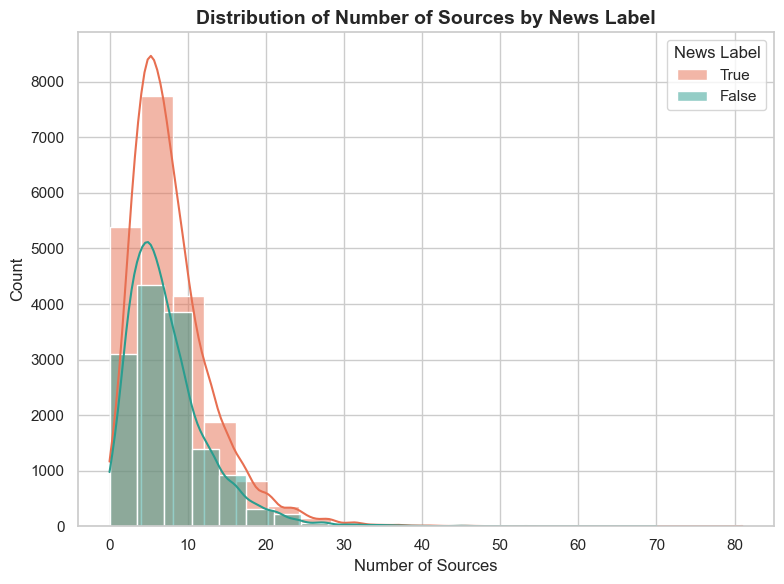

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df[df['news_label'] == 0]['num_sources'], color='#e76f51', label='True', kde=True, alpha=0.5, bins=20)
sns.histplot(df[df['news_label'] == 1]['num_sources'], color='#2a9d8f', label='False', kde=True, alpha=0.5, bins=20)

plt.title('Distribution of Number of Sources by News Label', fontsize=14, fontweight='bold')
plt.xlabel('Number of Sources')
plt.ylabel('Count')
plt.legend(title='News Label')
plt.tight_layout()
plt.show()

# 4.Train Machine Learning models

## Supervized learning

### Word Embedding

In [ ]:
# Load the cleaned dataset
df_vectorize = pd.read_csv('data/cleaned_dataset.csv')

# Combine statement and fullText_based_content for richer text features
df_vectorize['combined_text'] = df_vectorize['statement'].fillna('') + ' ' + df_vectorize['fullText_based_content'].fillna('')

# Initialize TF-IDF Vectorizer
# Using max_features to limit vocabulary size and improve performance
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=5,  # Ignore terms that appear in fewer than 5 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Fit and transform the combined text
text_features = tfidf.fit_transform(df_vectorize['combined_text'])

# Convert to DataFrame for easier manipulation
text_features_df = pd.DataFrame(
    text_features.toarray(),
    columns=[f'tfidf_{i}' for i in range(text_features.shape[1])]
)

# Combine TF-IDF features with numerical features
numerical_features = df_vectorize[['speaker_grouped', 'num_sources', 'has_official_source']]
numerical_features_reset = numerical_features.reset_index(drop=True)

# Concatenate all features
X_combined = pd.concat([numerical_features_reset, text_features_df], axis=1)
y = df_vectorize['news_label'].reset_index(drop=True)

print(f'Combined feature shape: {X_combined.shape}')
print(f'TF-IDF features: {text_features.shape[1]}')
print(f'Numerical features: {numerical_features.shape[1]}')
print(f'Total features: {X_combined.shape[1]}')

# Save the vectorizer for later use in production
joblib.dump(tfidf, 'models/tfidf_vectorizer.joblib')
print('\nTF-IDF Vectorizer saved to models/tfidf_vectorizer.joblib')

Combined feature shape: (34907, 1003)
TF-IDF features: 1000
Numerical features: 3
Total features: 1003

TF-IDF Vectorizer saved to models/tfidf_vectorizer.joblib


In [ ]:
# Split data into train (80%), validation (10%), and test (10%)

# Step 1: Split into train and temp (80% / 20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Step 2: Split temp into validation and test (10% / 10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp
)

print(f'Train shape: {X_train.shape} | Labels: {y_train.shape}')
print(f'Validation shape: {X_val.shape} | Labels: {y_val.shape}')
print(f'Test shape: {X_test.shape} | Labels: {y_test.shape}')

print(f'\nTrain label distribution:\n{y_train.value_counts(normalize=True)}')
print(f'\nValidation label distribution:\n{y_val.value_counts(normalize=True)}')
print(f'\nTest label distribution:\n{y_test.value_counts(normalize=True)}')

# Save processed data for later use
X_train.to_csv('data/X_train.csv', index=False)
X_val.to_csv('data/X_val.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_val.to_csv('data/y_val.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

Train shape: (27925, 1003) | Labels: (27925,)
Validation shape: (3491, 1003) | Labels: (3491,)
Test shape: (3491, 1003) | Labels: (3491,)

Train label distribution:
news_label
0    0.590546
1    0.409454
Name: proportion, dtype: float64

Validation label distribution:
news_label
0    0.590375
1    0.409625
Name: proportion, dtype: float64

Test label distribution:
news_label
0    0.590662
1    0.409338
Name: proportion, dtype: float64


In [ ]:
#Load train, test & validation data
X_test = pd.read_csv('data/X_test.csv')
X_val = pd.read_csv('data/X_val.csv')
X_test = pd.read_csv('data/X_test.csv')

y_train = pd.read_csv('data/y_train.csv')
y_val = pd.read_csv('data/y_val.csv')
y_test = pd.read_csv('data/y_test.csv')

### XGBoost

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    objective='binary:logistic',  
    eval_metric='logloss'
)

In [ ]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True,
)

[0]	validation_0-logloss:0.67014
[1]	validation_0-logloss:0.66427
[2]	validation_0-logloss:0.65885
[3]	validation_0-logloss:0.65392
[4]	validation_0-logloss:0.64932
[5]	validation_0-logloss:0.64497
[6]	validation_0-logloss:0.64099
[7]	validation_0-logloss:0.63730
[8]	validation_0-logloss:0.63374
[9]	validation_0-logloss:0.63048
[10]	validation_0-logloss:0.62732
[11]	validation_0-logloss:0.62461
[12]	validation_0-logloss:0.62166
[13]	validation_0-logloss:0.61919
[14]	validation_0-logloss:0.61669
[15]	validation_0-logloss:0.61431
[16]	validation_0-logloss:0.61186
[17]	validation_0-logloss:0.60973
[18]	validation_0-logloss:0.60755
[19]	validation_0-logloss:0.60570
[20]	validation_0-logloss:0.60348
[21]	validation_0-logloss:0.60169
[22]	validation_0-logloss:0.59992
[23]	validation_0-logloss:0.59845
[24]	validation_0-logloss:0.59657
[25]	validation_0-logloss:0.59509
[26]	validation_0-logloss:0.59362
[27]	validation_0-logloss:0.59211
[28]	validation_0-logloss:0.59068
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('\nXGBoost Training Complete!')
print(f'Test Accuracy: {acc:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))


XGBoost Training Complete!
Test Accuracy: 0.7451

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79      2062
           1       0.71      0.64      0.67      1429

    accuracy                           0.75      3491
   macro avg       0.74      0.73      0.73      3491
weighted avg       0.74      0.75      0.74      3491


Confusion Matrix:
 [[1682  380]
 [ 510  919]]


In [ ]:
#save the XGBoost model
joblib.dump(xgb_model, 'models/XGBoost_model.joblib')

['models/XGBoost_model.joblib']

### Random forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

In [ ]:
rf_model.fit(
    X_train, y_train,
)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('\nRandom Forest Metrics')
print(f'Test Accuracy: {acc:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))


Random Forest Metrics
Test Accuracy: 0.7771

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82      2062
           1       0.75      0.69      0.72      1429

    accuracy                           0.78      3491
   macro avg       0.77      0.76      0.77      3491
weighted avg       0.78      0.78      0.78      3491


Confusion Matrix:
 [[1734  328]
 [ 450  979]]


In [ ]:
#save the Random Forest model
joblib.dump(rf_model, 'models/RF_model.joblib')

['models/RF_model.joblib']

## Unsupervized learning

### K-Means Clustering

In [ ]:
X_train = pd.read_csv('data/X_train.csv')
print(f'Original X_train shape: {X_train.shape}')

Original X_train shape: (27925, 1003)


In [ ]:
pca = PCA(
    n_components=100,
    random_state=42
)
X_reduced = pca.fit_transform(X_train)

In [ ]:
k_range = range(2,11)
inertias = []
silhouette_scores = []

In [ ]:
for k in k_range:
    k_means_model = KMeans(n_clusters=k, random_state=42,n_init=10)
    labels = k_means_model.fit_predict(X_reduced)
    #Store inertia
    inertias.append(k_means_model.inertia_)
    #Calculate silhouette_score
    sil_score = silhouette_score(X_reduced,labels)
    silhouette_scores.append(sil_score)
    print(f'k={k}: Inertia={k_means_model.inertia_:.2f}, Silhouette Score={sil_score:.4f}')




k=2: Inertia=1591098.16, Silhouette Score=0.6396
k=3: Inertia=1193879.41, Silhouette Score=0.5819
k=4: Inertia=832159.13, Silhouette Score=0.5330
k=5: Inertia=591934.51, Silhouette Score=0.5380
k=6: Inertia=484551.02, Silhouette Score=0.4966
k=7: Inertia=407124.36, Silhouette Score=0.4707
k=8: Inertia=361789.87, Silhouette Score=0.4268
k=9: Inertia=322313.74, Silhouette Score=0.4435
k=10: Inertia=301435.31, Silhouette Score=0.4456


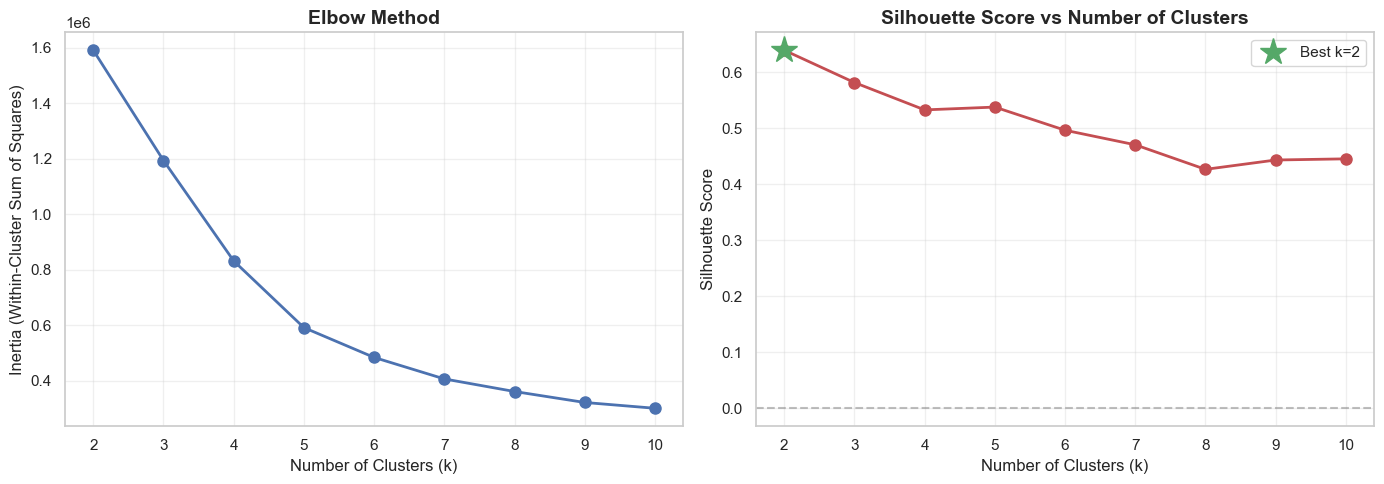

In [ ]:
# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method Plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_range)

# Silhouette Score Plot
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_range)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Highlight the best silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
ax2.plot(best_k, best_score, 'g*', markersize=20, label=f'Best k={best_k}')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Fit k=2 clustering on the PCA-reduced data
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_reduced)

# Add cluster labels to a dataframe for easy handling
X_train['cluster'] = cluster_labels

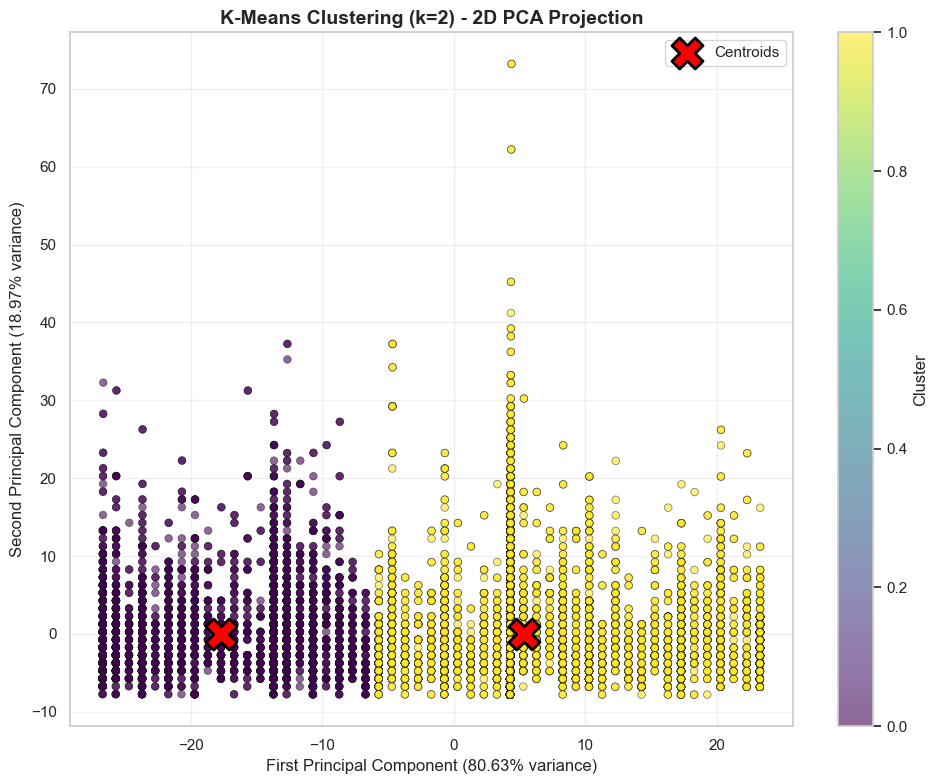

In [ ]:
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_reduced)

# Transform cluster centers to 2D space
centers_2d = pca_2d.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(10, 8))

# Plot the data points
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
                     cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.5)

# Plot the centroids
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
           c='red', marker='X', s=500, edgecolors='black', linewidth=2,
           label='Centroids', zorder=5)

plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('K-Means Clustering (k=2) - 2D PCA Projection', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(kmeans_final, 'models/kmeans_model.joblib')


['models/kmeans_model.joblib']